# Community detection for identifying WUJ pages

### Read graph

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [33]:
G = nx.read_gpickle("../data/processed/5_hits_per_contentID_graph.gpickle")
sab_pages = pd.read_csv("../data/processed/sab_pages.csv").pagePath.tolist()

### Helper functions

In [36]:
def evaluate(true_pages, predicted_pages):
    '''
    true_pages is a list of all the pages known to belong to a WUJ
    predicted_pages ia a list of pages predicted to belong to a WUJ
    
    returns precision and recall as percentages
    '''
    
    true_pages = set(true_pages)
    predicted_pages = set(predicted_pages)
    
    # what proportion of true pages were correctly predicted?
    recall = len(true_pages.intersection(predicted_pages))/len(true_pages)*100
    
    # what proportion of predicted pages are true pages?
    precision = len(true_pages.intersection(predicted_pages))/len(predicted_pages)*100
    
    return (precision, recall)

def getSlugs(G):
    '''
    Returns a list of slugs, given a networkx graph G.
    '''
    return [node[1]['properties']['name'] for node in G.nodes(data=True)]

def showGraph(G):
    print(nx.info(G))
    plt.figure(figsize=((12,12)))
    nx.draw(G)

# Random walks

In [35]:
def random_walk(G, steps, seed, nodeData=False):
    '''
    G is a networkx graph.
    steps is the number of steps to take in the random walk.
    seed is a page slug for your starting node in the random walk. E.g. "/set-up-business" 
    
    returns a numpy array of node ids visited during the random walk.
    can return numpy array of nodes with their data if nodeData == True
    '''
    
    # get adjacency matrix A
    A = nx.adj_matrix(G, weight=None)
    #A = np.array(A.todense())

    # set a seed node
    foundSeed = False
    for current_node_index, node in enumerate(G.nodes(data=True)):
        if node[1]["properties"]["name"] == seed:
            foundSeed = True
            break
    
    assert foundSeed == True, "Could not find seed node: {}".format(seed)

    # list of nodes visited during the random walk
    visited = [current_node_index]

    for step in range(steps):

        # identify neighbours of current node
        neighbours = np.nonzero(A[current_node_index])[1]

        # if reached an absorbing state, i.e. no neighbours, then terminate the random walk
        if neighbours.size == 0:
            #print("Reached absorbing state after", step, "steps")
            visited = list(set(visited))
            return np.array(G.nodes(data=nodeData))[visited]
            
        # randomly select the index of next node to transition to
        current_node_index = np.random.choice(neighbours)

        # maintain record of the path taken by the random walk
        visited.append(current_node_index)
    
    # return unique pages visited
    visited = list(set(visited))
        
    return np.array(G.nodes(data=nodeData))[visited]

In [86]:
def random_walk(A, G, steps, seed, nodeData=False):
    '''
    A is an adjacency matrix.
    G is a networkx graph.
    steps is the number of steps to take in the random walk.
    seed is a page slug for your starting node in the random walk. E.g. "/set-up-business" 
    
    returns a numpy array of node ids visited during the random walk.
    can return numpy array of nodes with their data if nodeData == True
    '''

    # set a seed node
    foundSeed = False
    for current_node_index, node in enumerate(G.nodes(data=True)):
        if node[1]["properties"]["name"] == seed:
            foundSeed = True
            break
    
    assert foundSeed == True, "Could not find seed node: {}".format(seed)

    # list of nodes visited during the random walk
    visited = [current_node_index]

    for step in range(steps):

        # identify neighbours of current node
        neighbours = np.nonzero(A[current_node_index])[1]

        # if reached an absorbing state, i.e. no neighbours, then terminate the random walk
        if neighbours.size == 0:
            #print("Reached absorbing state after", step, "steps")
            visited = list(set(visited))
            return np.array(G.nodes(data=nodeData))[visited]
            
        # randomly select the index of next node to transition to
        current_node_index = np.random.choice(neighbours)

        # maintain record of the path taken by the random walk
        visited.append(current_node_index)
    
    # return unique pages visited
    visited = list(set(visited))
        
    return np.array(G.nodes(data=nodeData))[visited]

## Naive random walk

Here we're testing the most basic form of random walk, in which a random walk is initialised from a seed page, thereafter successively transitioning to neighbouring nodes, with uniformly distributed transition probabilities. One random walk is initialised per seed node. Each "start a business" page is used as a seed node. The precision and recall of the random walks starting from each of these seed nodes is computed.

In [87]:
# get adjacency matrix of G
A = nx.adj_matrix(G, weight=None)

In [88]:
precisions = []
recalls = []

# number of steps to take in random walk
N = 1000

for sab_page in tqdm(sab_pages):
    pred = getSlugs(G.subgraph(random_walk(A, G, N, sab_page)))
    p, r = evaluate(sab_pages, pred)
    precisions.append(p)
    recalls.append(r)

  0%|          | 0/306 [00:00<?, ?it/s]

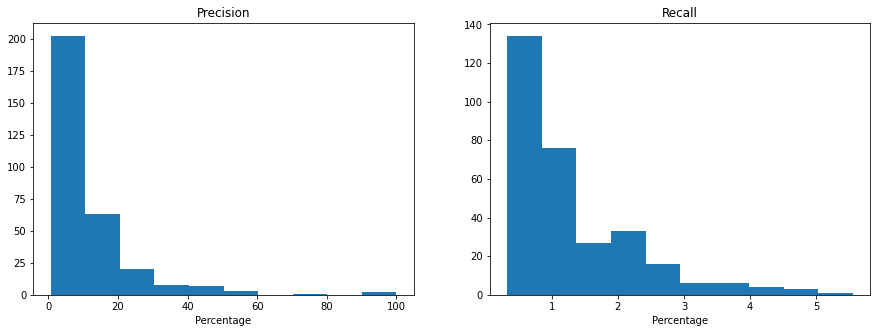

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(precisions);
ax[0].set_title("Precision");
ax[0].set_xlabel("Percentage");
ax[1].hist(recalls);
ax[1].set_title("Recall");
ax[1].set_xlabel("Percentage");

Precision and recall are typically around 10% and 1%, respectively.

### Seed node analysis

Which seed nodes recalled the most SaB pages? Here is the top 10:

In [46]:
sorted(list(zip(recalls, sab_pages)), key=lambda x: -x[0])[:10]

[(7.18954248366013, '/closing-a-limited-company'),
 (6.862745098039216, '/health-and-safety-for-farm-vehicles'),
 (5.228758169934641, '/send-vat-return'),
 (4.901960784313726, '/calculate-your-business-rates'),
 (4.57516339869281, '/special-training-ratings-officers'),
 (4.57516339869281, '/renew-patent'),
 (4.248366013071895, '/creative-works-licence'),
 (4.248366013071895, '/hazardous-waste-producer-registration-wales'),
 (4.248366013071895, '/online-and-distance-selling-for-businesses'),
 (4.248366013071895, '/skip-licence-scotland')]

Since only one random walk is initialised per seed node, these results could happen by chance. Hence, we now initialise multiple random walks per seed node. Then, compute the average precision and recall per seed node, to see if a particular node does best on average.

In [ ]:
# these lists will be lists of lists, where each sublist
# contains the precisions and recalls of the repeat random walks
# for a given seed node. e.g.

#                  sab_page_1       sab_page_2              sab_page_n
# precisions = [[0.1,0.15,0.12], [0.2,0.19,0.21], . . ., [0.3, 0.25, 0.12]]

#                                              sab_page_1  sab_page_2    sab_page_n
# then we can compute means: mean_precisions = [0.123,      0.199, . . ., 0.223]

precisions = []
recalls = []

# number of steps to take in random walk
N = 1000

# number of repeats per seed node
repeats = 100

for sab_page in tqdm(sab_pages):
    
    # to store the precision and recall scores
    # per seed page, for each repeat
    ps = []
    rs = []
    
    for repeat in range(repeats):
        pred = getSlugs(G.subgraph(random_walk(A, G, N, sab_page)))
        p, r = evaluate(sab_pages, pred)
        ps.append(p)
        rs.append(r)
        
    precisions.append(ps)
    recalls.append(rs)

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
mean_recalls = [np.mean(r) for r in recalls]
mean_precisions = [np.mean(p) for p in precisions]

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(mean_precisions);
ax[0].set_title("Precision");
ax[0].set_xlabel("Percentage");
ax[1].hist(mean_recalls);
ax[1].set_title("Recall");
ax[1].set_xlabel("Percentage");

In [ ]:
sorted(list(zip(mean_recalls, sab_pages)), key=lambda x: -x[0])[:10]

## Repeated random walk

Let's use the 3 seed pages with the highest recall from the previous section as seed nodes, then perform M random walks beginning from each of these seed nodes. Hence, we get 3*M sets of pages. The union of these sets is used to define a set of pages related to the SaB WUJ.

In [43]:
top3_sab_pages = sorted(list(zip(recalls, sab_pages)), key=lambda x: -x[0])[:3]
top3_sab_pages = [x[1] for x in top3_sab_pages]
top3_sab_pages

['/closing-a-limited-company',
 '/health-and-safety-for-farm-vehicles',
 '/send-vat-return']

In [40]:
precisions = []
recalls = []

# number of times to initialise random walk from a given seed node
M = 100

# number of steps to take in random walk
N = 1000

pages_visited = list()

for sab_page in tqdm(top3_sab_pages):
    for m in tqdm(range(M)):
        pages_visited.extend(getSlugs(G.subgraph(random_walk(G, N, sab_page))))
        
pages_visited = list(set(pages_visited))
        
p, r = evaluate(sab_pages, pages_visited)

NameError: name 'top3_sab_pages' is not defined

In [33]:
p,r, len(pages_visited)

(1.374588684852988, 84.640522875817, 18842)

In [34]:
len(set(pages_visited).intersection(set(sab_pages)))

259

### Seed node sensitivity

We need to know how sensitive results are to the choice of seed nodes. Hence, 

# Biased random walks

Previously, transition probabilities were uniformly distributed. Hence, the random walk treated all neighbouring nodes as equal. In reality, information from the random walk so far can inform which node to transition to. Now, transition probabilities will be biased using such information, to increase the probability of moving towards nodes that are more relevant to a WUJ.

## Node2vec